In [1]:
import datautil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import matplotlib.patheffects as path_effects
import networkx as nx
import seaborn as sns
from collections import Counter

In [2]:
projects = datautil.select_projects_from_libraries_io()
libraries = datautil.select_libraries()
lib_names = set(libraries["name"])
rules = datautil.select_rules(lib_names)
dep_changes = datautil.select_dependency_changes_all(lib_names)
migrations = datautil.select_migrations()

print(f"{len(set(migrations.fromLib))} source libs, {len(set(migrations.toLib))} target libs, {len(set(migrations.fromLib) | set(migrations.toLib))} total libs")
print(f"{len(set(migrations.startCommit) | set(migrations.endCommit))} total commits")
print(f"{len(set(migrations.repoName))} repositories")
print(f"{len(set(zip(migrations.fromLib, migrations.toLib)))} migration rules")

390 source libs, 562 target libs, 716 total libs
3163 total commits
1601 repositories
1194 migration rules


In [3]:
valid_projects = dep_changes[dep_changes.lib2.isin(set(migrations.fromLib))].project
projects = projects[projects.nameWithOwner.isin(valid_projects)]
dep_changes = dep_changes[dep_changes.project.isin(valid_projects)]
print(f"{len(projects)} projects, {len(dep_changes)} dep changes")

17681 projects, 3322438 dep changes


In [4]:
cls2 = pd.read_excel("data/cls2.xlsx")
lib2category = dict(zip(cls2.package, cls2.adjusted_category))
lib2popularity = dict(zip(libraries.name, libraries.dependentRepositoriesCount))

In [5]:
rules["fromLibCategory"] = rules.fromLib.map(lambda x: lib2category[x])
rules["toLibCategory"] = rules.toLib.map(lambda x: lib2category[x])
rules["numRepositories"] = [len(set(migrations[(migrations.fromLib == from_lib) & (migrations.toLib == to_lib)].repoName))
                            for from_lib, to_lib in zip(rules.fromLib, rules.toLib)]
rules.head()

,fromLib,toLib,fromLibCategory,toLibCategory,numRepositories
0,ant:ant,org.apache.ant:ant,Build,Build,15
1,ant:ant,org.apache.ant:ant-apache-regexp,Build,Build,1
2,ant:ant,org.apache.ant:ant-junit,Build,Build,1
3,ant:ant,org.apache.ant:ant-nodeps,Build,Build,3
4,ant:ant,org.apache.ant:ant-trax,Build,Build,1


Counter({'Webservice': 182, 'Logging': 161, 'JSON': 153, 'Testing': 152, 'Other': 141, 'XML': 42, 'Database': 36, 'Persistence': 31, 'Bytecode': 26, 'Dependency Injection': 25, 'HTTP Clients': 20, 'JDBC Pools': 19, 'Metrics': 17, 'Build': 14, 'Command Line': 13})


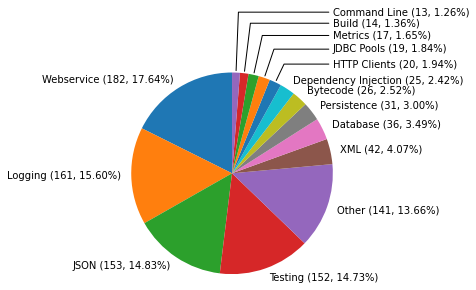

In [6]:
catdis = Counter(rules[rules.fromLibCategory == rules.toLibCategory].fromLibCategory)
for key in list(catdis.keys()):
    if key != "other" and catdis[key] < 13:
        catdis["Other"] += catdis[key]
        del catdis[key]
print(catdis)
data = sorted(catdis.items(), key=lambda x: -x[1])
labels = [f"{x[0]} ({x[1]}, {100 * x[1] / sum(catdis.values()):.2f}%)" for x in data]
fig, ax = plt.subplots(figsize=(4,4))
patches, texts = ax.pie([x[1] for x in data], labels=labels[0:10] + [""] * (len(labels) - 10),
        shadow=False, startangle=90, labeldistance=1.1, pctdistance=0.8)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
for i in range(-5, 0):
    p = patches[i]
    ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1*np.sign(x), (1.7 + 0.1 * i) *y),
                horizontalalignment=horizontalalignment, **kw)
fig.savefig("plots/migration_category.pdf", bbox_inches="tight")

In [7]:
web_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "Webservice")]
print(f"{len(web_rules)} rules, {len(set(web_rules.fromLib) | set(web_rules.toLib))} libraries")

182 rules, 114 libraries


In [8]:
logging_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "Logging")]
print(f"{len(logging_rules)} rules, {len(set(logging_rules.fromLib) | set(logging_rules.toLib))} libraries")

161 rules, 35 libraries


In [9]:
json_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "JSON")]
print(f"{len(json_rules)} rules, {len(set(json_rules.fromLib) | set(json_rules.toLib))} libraries")

153 rules, 39 libraries


In [10]:
test_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "Testing")]
print(f"{len(test_rules)} rules, {len(set(test_rules.fromLib) | set(test_rules.toLib))} libraries")

152 rules, 73 libraries


All:     30.72% (157), 5.48% (28), 13.89% (71), 8.81% (45), 41.10% (210)
Logging: 19.23% (5), 3.85% (1), 26.92% (7), 26.92% (7), 23.08% (6)
JSON:    30.00% (9), 13.33% (4), 16.67% (5), 0.00% (0), 40.00% (12)
Web:     32.18% (28), 3.45% (3), 6.90% (6), 6.90% (6), 50.57% (44)
Test:    25.00% (12), 8.33% (4), 16.67% (8), 10.42% (5), 39.58% (19)


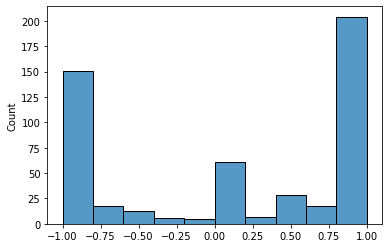

In [11]:
def get_migration_graph(subrules):
    migration_graph = nx.DiGraph()
    for lib in set(subrules.fromLib) | set(subrules.toLib):
        if lib2popularity[lib] >= 500:
            migration_graph.add_node(lib, pop=lib2popularity[lib])
    for idx, rule in subrules.iterrows():
        if lib2popularity[rule.fromLib] >= 500 and lib2popularity[rule.toLib] >= 500:
            migration_graph.add_edge(rule.fromLib, rule.toLib, weight=rule.numRepositories)
    return migration_graph
def get_node_flows(migration_graph):
    result = []
    for node in migration_graph.nodes():
        ind = migration_graph.in_degree(node, "weight")
        outd = migration_graph.out_degree(node, "weight")
        result.append((ind - outd) / max(1, outd, ind))
    return result
def print_flow_dis(data):
    x1, x2, x3, x4, x5 = 0, 0, 0, 0, 0
    for i in data:
        if i <= -0.75:
            x1 += 1
        elif i <= -0.25:
            x2 += 1
        elif i <= 0.25:
            x3 += 1
        elif i < 0.75:
            x4 += 1
        else:
            x5 += 1
    y = sum([x1, x2, x3, x4, x5])
    print(f"{100 * x1 / y:.2f}% ({x1}), {100 * x2 / y:.2f}% ({x2}), {100 * x3 / y:.2f}% ({x3}), {100 * x4 / y:.2f}% ({x4}), {100 * x5 / y:.2f}% ({x5})")
logging_graph = get_migration_graph(logging_rules)
json_graph = get_migration_graph(json_rules)
web_graph = get_migration_graph(web_rules)
test_graph = get_migration_graph(test_rules)
all_graph = get_migration_graph(rules)
print("All:     ", end="")
print_flow_dis(get_node_flows(all_graph))
print("Logging: ", end="")
print_flow_dis(get_node_flows(logging_graph))
print("JSON:    ", end="")
print_flow_dis(get_node_flows(json_graph))
print("Web:     ", end="")
print_flow_dis(get_node_flows(web_graph))
print("Test:    ", end="")
print_flow_dis(get_node_flows(test_graph))
sns.histplot(get_node_flows(all_graph))
plt.savefig("plots/flow.pdf", bbox_inches="tight")

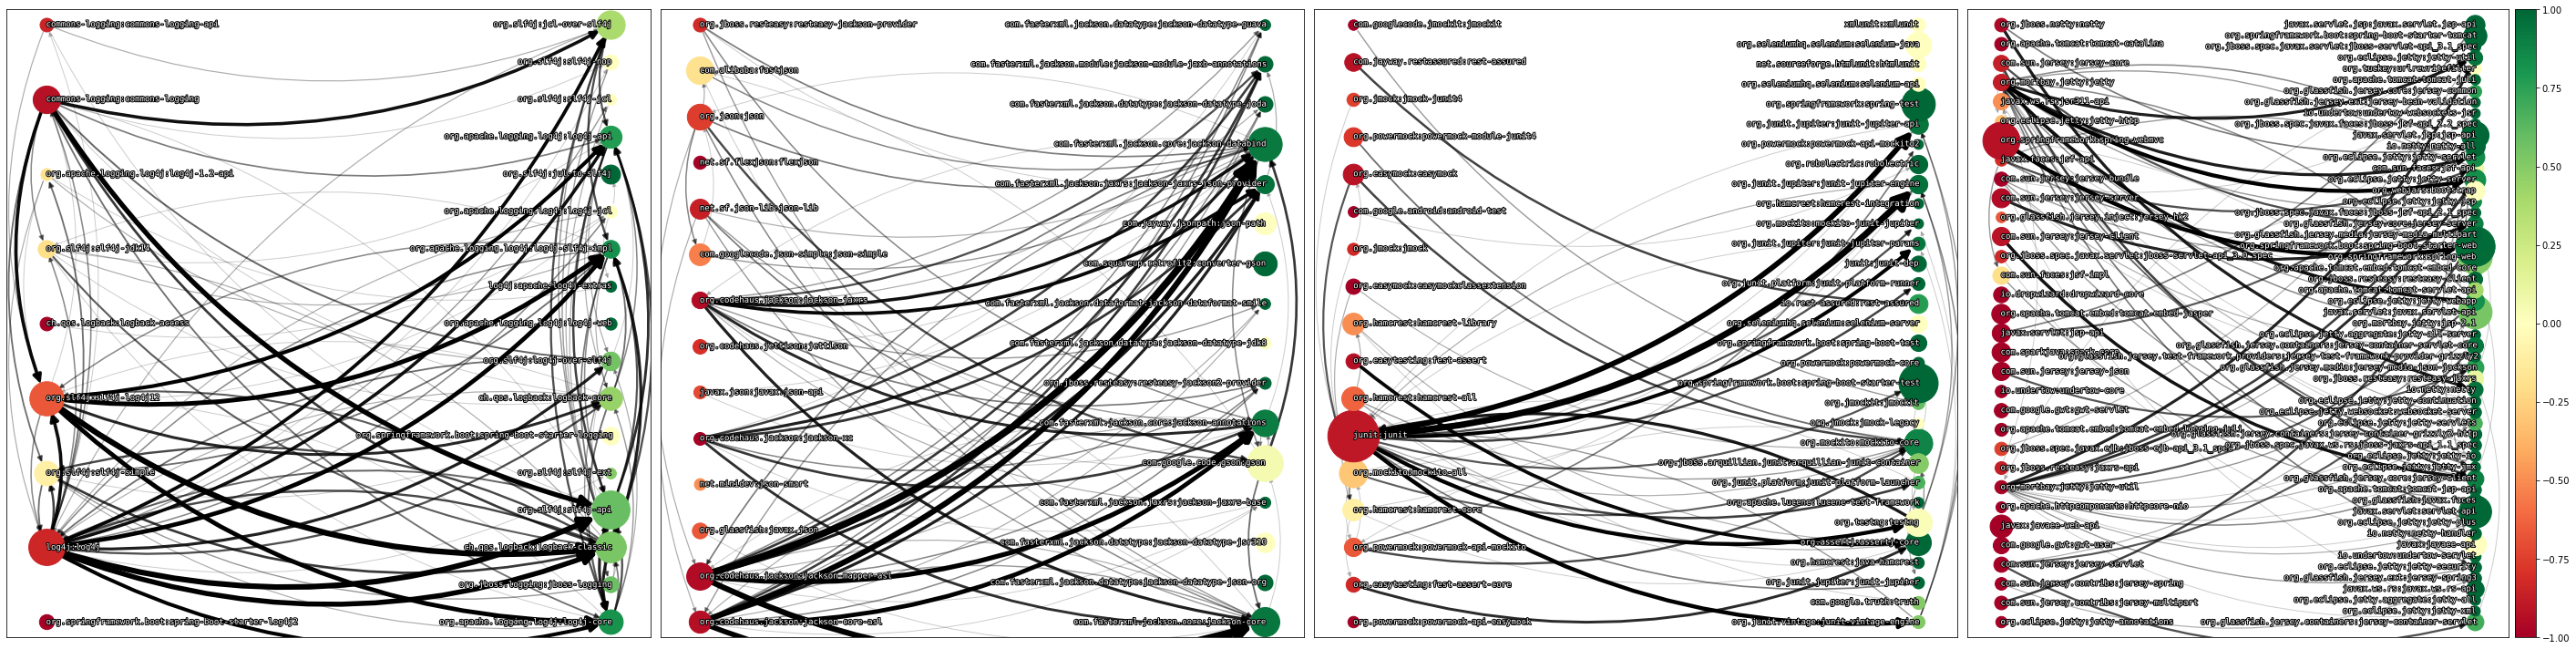

In [12]:
def visualize_migration_graph(migration_graph, ax):
    nodes = migration_graph.nodes()
    edges = migration_graph.edges()

    nodes_left = []
    for node in nodes:
        ind = migration_graph.in_degree(node, "weight")
        outd = migration_graph.out_degree(node, "weight")
        if ind < outd:
            nodes_left.append(node)
    pos = nx.bipartite_layout(migration_graph, nodes=nodes_left, aspect_ratio=0.5, scale=1, center=(0.0,0.0))
    
    label_pos_left, label_pos_right = dict(), dict()
    for node in nodes:
        if node in nodes_left:
            label_pos_left[node] = pos[node]
        else:
            label_pos_right[node] = pos[node]
            
    for i, edge in enumerate(edges):
        weight = migration_graph.edges[edge]["weight"]
        nx.draw_networkx_edges(migration_graph, pos, edgelist=[edge], ax=ax,
                           arrows=True, connectionstyle="arc3,rad=0.2",
                           width=0.7*np.sqrt(weight),
                           alpha=min(1.0,0.2*np.log2(weight)),
                           arrowsize=int(0.3*weight) + 10,
                           min_target_margin=migration_graph.nodes[edge[1]]["pop"] ** 0.25)
    for i, node in enumerate(nodes):
        ind = migration_graph.in_degree(node, "weight")
        outd = migration_graph.out_degree(node, "weight")
        nx.draw_networkx_nodes(migration_graph, pos, nodelist=[node], ax=ax,
                               node_size=5*np.sqrt(migration_graph.nodes[node]["pop"]),
                               node_color=(ind - outd) / max(1, outd, ind),
                               cmap="RdYlGn",
                               vmin=-1.0,
                               vmax=1.0)
    text_items = nx.draw_networkx_labels(migration_graph, pos=label_pos_left, labels={k:k for k in label_pos_left}, 
                                         ax=ax, font_size=9, font_family="monospace", font_color="white", 
                                         horizontalalignment="left")
    text_items.update(
        nx.draw_networkx_labels(migration_graph, pos=label_pos_right, labels={k:k for k in label_pos_right},
                                         ax=ax, font_size=9, font_family="monospace", font_color="white", 
                                         horizontalalignment="right"))
    for text in text_items.values():
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
        
    xmin, xmax = min(x[0] for x in pos.values()), max(x[0] for x in pos.values())
    ax.set_xlim(xmin - 0.07, xmax + 0.07)
    ymin, ymax = min(x[1] for x in pos.values()), max(x[1] for x in pos.values())
    ax.set_ylim(ymin - 0.05, ymax + 0.05)
fig, axes = plt.subplots(1, 4, figsize=(40,10))
visualize_migration_graph(logging_graph, ax=axes[0])
visualize_migration_graph(json_graph, ax=axes[1])
visualize_migration_graph(test_graph, ax=axes[2])
visualize_migration_graph(web_graph, ax=axes[3])
fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-1.0, vmax=1.0), cmap="RdYlGn"),
        ax=axes[3], pad=0.01, aspect=30)
fig.tight_layout()
fig.savefig("plots/graph.pdf", bbox_inches="tight")
fig.savefig("plots/graph.png", bbox_inches="tight", dpi=150)
fig.savefig("plots/graph-dpi300.png", bbox_inches="tight", dpi=300)